In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
import lda
import os
import pdb
import nltk
import string
import json
import random
import pickle
import pandas as pd
import seaborn as sns

from IPython.display import clear_output
from os import makedirs
from os.path import join, exists

In [3]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

In [4]:
INPUT_DIR = join('tmp', 'parsed')
OUTPUT_DIR = join('tmp')
makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
from nltk.stem.porter import PorterStemmer

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

In [6]:
print("Building vocabulary...")

docs = {}
doc_tokens = {}
for fname in os.listdir(INPUT_DIR):
    if fname != '.DS_Store':
        with open(join(INPUT_DIR, fname), 'r') as f:
            doc = json.load(f)
            docs[doc['id']] = doc
            text = doc['body']
            table = str.maketrans({key: None for key in string.punctuation})
            text = text.lower().translate(table)
            doc_tokens[doc['id']] = text

token_keys = [x[0] for x in doc_tokens.items()]
token_values = [x[1] for x in doc_tokens.items()]
print(len(doc_tokens.items()))

Building vocabulary...
9086


In [5]:
docs = pickle.load(open('tmp/docs_topic_most_pr.pickle', 'rb'))

In [22]:
print(docs['2016-05-24-283']['keywords'])
print(docs['2016-05-24-283']['topic_most_pr'])

    feature     tfidf
0    steven  0.380072
1     labor  0.238017
2        wa  0.188815
3    econom  0.154423
4      hole  0.153102
5   leverag  0.149618
6      bank  0.137245
7    whomev  0.130504
8  morrison  0.124310
9    labor’  0.118211
21


# TF-IDF Vectorizer

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("Processing TF-IDF")

vectorizer = TfidfVectorizer(tokenizer=tokenize, norm='l2', stop_words='english')
X_tfidf = vectorizer.fit_transform(token_values)

print(X_tfidf.shape)

Processing TF-IDF
(9086, 141273)


# Collect Keywords

In [6]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [7]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [8]:
for i, key in enumerate(token_keys):
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    docs[key]['keywords'] = top_feats_in_doc(X_tfidf, vectorizer.get_feature_names(), i, 10)
    
print(docs['2016-05-20-28']['keywords'])

   feature     tfidf
0     bull  0.337933
1   soccer  0.239934
2      red  0.209805
3     citi  0.193355
4  glidden  0.188261
5      nyc  0.183386
6       fc  0.167634
7   jersey  0.164249
8       ml  0.163835
9      fan  0.160802


In [9]:
pickle.dump(docs, open('tmp/docs.pickle', 'wb'))

In [77]:
docs = pickle.load(open('tmp/docs.pickle', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'tmp/docs.pickle'

# Add Vector to docs

In [164]:
for i, key in enumerate(token_keys):
    docs[key]['tfidf'] = X_tfidf[i]
  
docs['2016-05-20-28']['tfidf']

<1x141273 sparse matrix of type '<class 'numpy.float64'>'
	with 417 stored elements in Compressed Sparse Row format>

# Build the graph from scratch

In [300]:
g = ig.Graph()
for i, key in enumerate(token_keys):
    g.add_vertices(key)
    
print(g.vcount())

9086


In [301]:
g.delete_edges(g.es)
edges = []
for i, source in enumerate(token_keys):
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    for j, target in enumerate(token_keys):
        edges.append((source, target))
            
g.add_edges(edges)  
edges = [] 
print(g.ecount())

82555396


In [302]:
from sklearn.metrics.pairwise import cosine_similarity

count = 0
for i, source in enumerate(token_keys):
    similarities = cosine_similarity(X_tfidf[i], X_tfidf)[0]
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    for j, target in enumerate(token_keys):            
        g.es[count]["weight"] = similarities[j]
        count += 1

print(g.ecount())

82555396


Remove duplicated and self-loop edges

In [303]:
g.simplify(multiple=True, loops=True, combine_edges="max")
print(g.ecount())

41273155


In [14]:
g.es[1]['weight']

0.027366185195034684

In [15]:
g.write_gml('tmp/igraph.gml')

In [ ]:
g = ig.Graph.Read_GML('tmp/igraph.gml')

In [73]:
sub_g = g.es.select(weight_ge=0.1).subgraph()

In [75]:
print("Nodes {}".format(sub_g.vcount()))
print("Edges {}".format(sub_g.ecount()))
print("Diameter {}".format(sub_g.diameter()))
print("LCC {}".format(sub_g.clusters().giant().vcount()))
print("APL {}".format(sub_g.average_path_length()))
print("AD {}".format(sum(sub_g.degree())/len(sub_g.degree())))

Nodes 9086
Edges 41273155
AD 9085.0


In [23]:
print(sub_g.vs[1])
print(sub_g.vs[3])

igraph.Vertex(<igraph.Graph object at 0x10e1f0c78>, 0, {'name': '2016-05-01-122'})
igraph.Vertex(<igraph.Graph object at 0x10e1f0c78>, 3, {'name': '2016-05-01-81'})


In [39]:
sub_g.write_gml('tmp/subgraph_01.gml')

In [2]:
import textacy
import spacy

In [3]:
nlp = spacy.load('en')

In [31]:
doc = nlp(u"Rami Eid is studying at Stony Brook University in New York.")

In [32]:
for np in doc.noun_chunks:
    print(np.text)

Rami Eid
Stony Brook University
New York


# Load Network

In [14]:
g = ig.Graph.Read_GML('tmp/subgraph_01.gml')

In [304]:
def network_properties(g, community):
    print("Nodes {}".format(g.vcount()))
    print("Edges {}".format(g.ecount()))
    print("Diameter {}".format(g.diameter()))
    print("LCC {}".format(g.clusters().giant().vcount()))
    print("APL {}".format(g.average_path_length()))
    print("AD {}".format(sum(g.degree())/len(g.degree())))
    print("Giant Size {}".format(len(community.giant().vs())))
    print("NO of Communities {}".format(max(community.membership) + 1))
    print("Modularity {}".format(g.modularity(community.membership)))

In [305]:
sg = g.es.select(weight_ge=0.2).subgraph()

In [306]:
# community = sg.community_infomap(edge_weights='weight')
community = sg.community_multilevel(weights='weight')
# community = sg.community_leading_eigenvector(weights='weight')

In [308]:
network_properties(sg, community)

Nodes 7814
Edges 98164
Diameter 15
LCC 7356
APL 5.104654144972761
AD 25.125159969285896
Giant Size 612
NO of Communities 225
Modularity 0.8247291798030393


Show contents of communities

In [309]:
with open('tmp/network_docs.txt', 'w+') as file:
    for i in range(max(community.membership) + 1):
        for v in community.subgraph(i).vs():
            file.write("Topic:{} File:{} Title:{}\n".format(i, v['name'], docs[v['name']]['webTitle']))

# Network Size Chart

In [310]:
def community_to_size_chart(com):
    net_topics = {}

    for i in range(max(com.membership) + 1):
        for v in com.subgraph(i).vs():
            topic_no = i
            try:
                net_topics[topic_no]
            except KeyError:
                net_topics[topic_no] = 0

            net_topics[topic_no] += 1 

    x_data = []
    y_data = []
    for key, value in sorted(net_topics.items(), key=lambda x: x[1], reverse=True):
        x_data.append(key)
        y_data.append(value)

    ind = np.arange(0, len(y_data) * 2, 2)
    fig = plt.figure(figsize=(60,10))
    plt.bar(ind, y_data)
    plt.xticks(ind, x_data, rotation=90)
    plt.title("Topic Document Distribution")
    plt.xlabel("Topic")
    plt.ylabel("Frequency")
    fig.savefig('tmp/size_chart_net.png')
    plt.show()

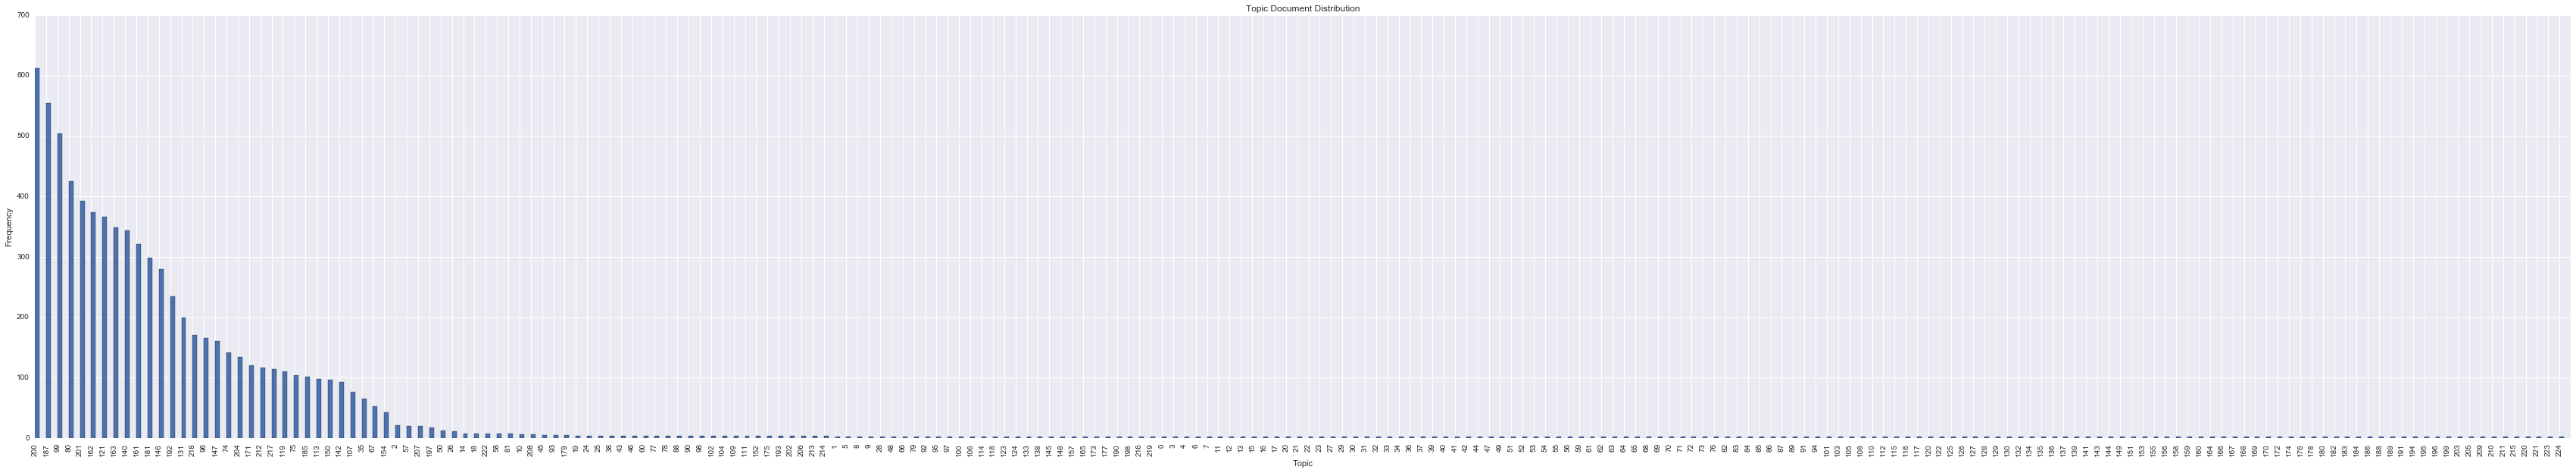

In [311]:
community_to_size_chart(community)

# LDA

In [39]:
from gensim import matutils
from gensim.models.ldamodel import LdaModel

In [58]:
from sklearn.feature_extraction.text import CountVectorizer

print("Processing Count")

vectorizer = CountVectorizer(tokenizer=tokenize, stop_words='english')
X_count = vectorizer.fit_transform(token_values)

print(X_count.shape)

(9086, 141273)


In [63]:
vocab = vectorizer.get_feature_names()

In [64]:
np.random.seed(1234)

gensim_model = LdaModel(matutils.Sparse2Corpus(X_count.T), 
                num_topics=226,
                passes=50,
                id2word=dict([(i, s) for i, s in enumerate(vocab)]))

In [66]:
pickle.dump(gensim_model, open('tmp/gensim_lda.pickle', 'wb'))

# Load LDA

In [113]:
lda_model = pickle.load(open('tmp/count_226_gensim_lda.pickle', 'rb'))

In [114]:
doc_topic_prob_mat = lda_model[matutils.Sparse2Corpus(X_count.T)]
print(len(doc_topic_prob_mat))

9086


In [72]:
for i, mat in enumerate(doc_topic_prob_mat):
    print('{0}\r'.format(i/len(doc_topic_prob_mat)))
    docs[token_keys[i]]['topic_most_pr'] = max(mat, key=lambda x: x[1])[0]
    clear_output(wait=True)

lda_items = sorted(docs.items(), key=lambda x: x[1]['topic_most_pr'])

0.9998899405679067


In [73]:
pickle.dump(lda_items, open('tmp/lda_items.pickle', 'wb'))

In [74]:
with open('tmp/lda_docs.txt', 'w+') as file:
    for item in lda_items:
        file.write("Topic:{} File:{} Title:{}\n".format(item[1]['topic_most_pr'], item[0], item[1]['webTitle']))

# LDA Size Chart

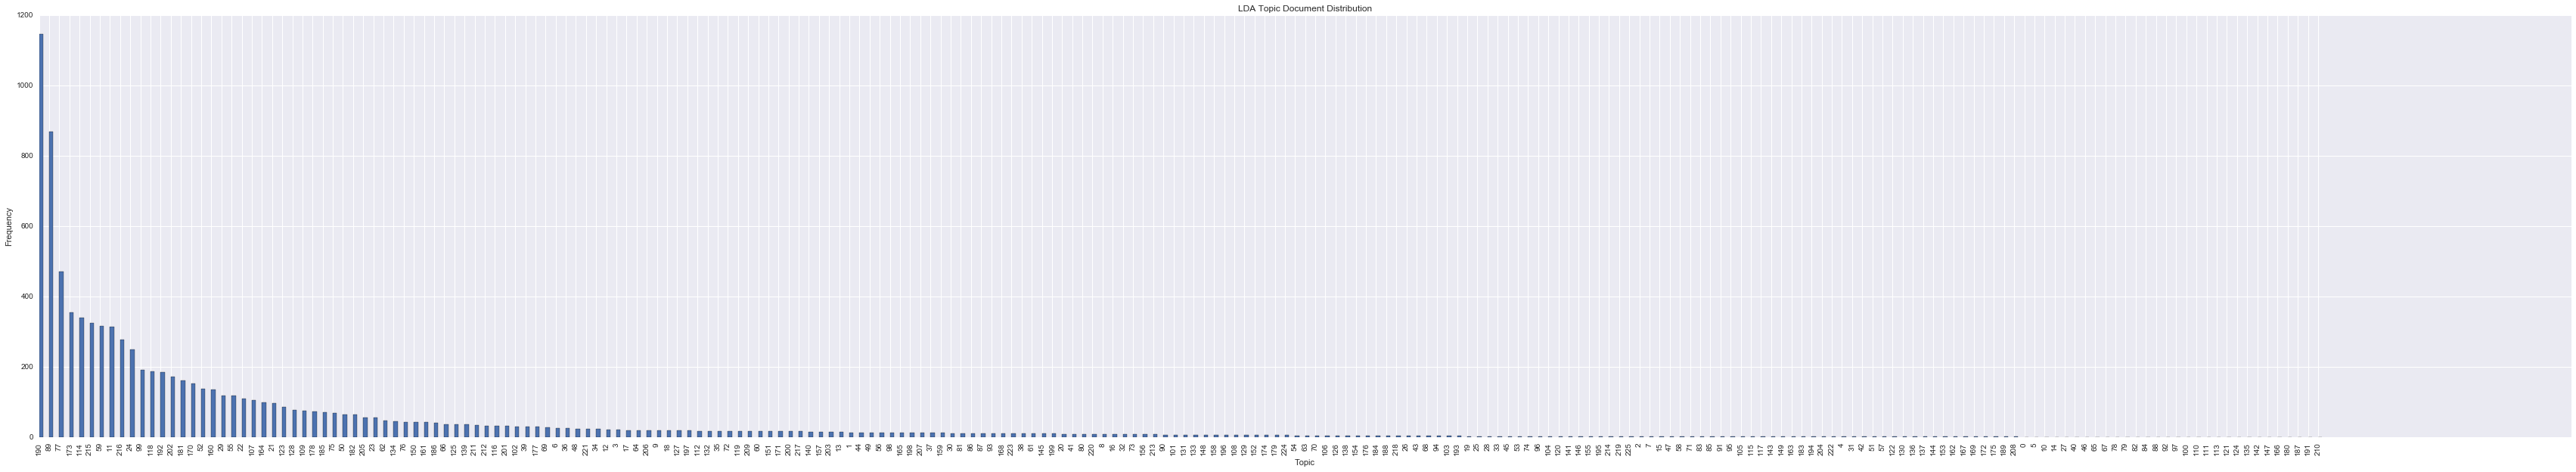

In [10]:
lda_items = pickle.load(open('tmp/count_226_lda_items.pickle', 'rb'))

lda_topics = {}

for i in range(226):
    lda_topics[i] = []
    
for item in lda_items:
    topic_no = item[1]['topic_most_pr']
    lda_topics[topic_no].append(item[0])
    
print(len(lda_topics.keys()))

x_data = []
y_data = []
for key, value in sorted(lda_topics.items(), key=lambda x: len(x[1]), reverse=True):
    x_data.append(key)
    y_data.append(len(value))

ind = np.arange(0, len(y_data) * 2, 2)
fig = plt.figure(figsize=(60,10))
plt.bar(ind, y_data)
plt.xticks(ind, x_data, rotation=90)
plt.title("LDA Topic Document Distribution")
plt.xlabel("Topic")
plt.ylabel("Frequency")
fig.savefig('tmp/size_chart_lda.png')
plt.show()

# Heatmap

In [11]:
def community_to_heatmap_data(com):
    topics = {}

    for i in range(max(com.membership) + 1):
        for v in com.subgraph(i).vs():
            topic_no = i
            try:
                topics[topic_no]
            except KeyError:
                topics[topic_no] = []

            topics[topic_no].append(v['name'])

    d = []
    for key, value in sorted(topics.items(), key=lambda x: x[0]):
        h = {}
        for v in value:
            h[v] = True
        d.append(h)

    print(len(d))
    print(d[0])
    return(d)

In [12]:
def lda_topics_to_heatmap_data(lda_topics):
    topics = {}

    topics = lda_topics

    d = []
    for key, value in sorted(topics.items(), key=lambda x: x[0]):
        h = {}
        for v in value:
            h[v] = True
        d.append(h)

    print(len(d))
    print(d[1])
    return d

In [18]:
net_data = community_to_heatmap_data(community)
#lda_data = community_to_heatmap_data(community_lda)
lda_data = lda_topics_to_heatmap_data(lda_topics)

227
{'2016-05-01-3': True, '2016-05-02-13': True}
226
{'2016-05-18-63': True, '2016-05-20-24': True, '2016-05-27-195': True, '2016-05-25-267': True, '2016-05-19-60': True, '2016-05-13-266': True, '2016-05-20-98': True, '2016-05-13-143': True, '2016-05-19-190': True, '2016-05-19-9': True, '2016-05-13-44': True, '2016-05-14-142': True, '2016-05-13-331': True}


In [19]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()
vectors  = net_data + lda_data
X_dict = vectorizer.fit_transform(vectors)

print(X_dict.shape)

(453, 9086)


In [20]:
print(len(net_data[0].keys()))
print(len(lda_data[0].keys()))
print(np.count_nonzero(X_dict[:226].toarray()[0]))

2
0
2


In [21]:
net_vectors = X_dict[:227]
lda_vectors = X_dict[227:]

In [41]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(net_vectors, lda_vectors)

In [23]:
pickle.dump(similarities, open('tmp/similarities.pickle', 'wb'))

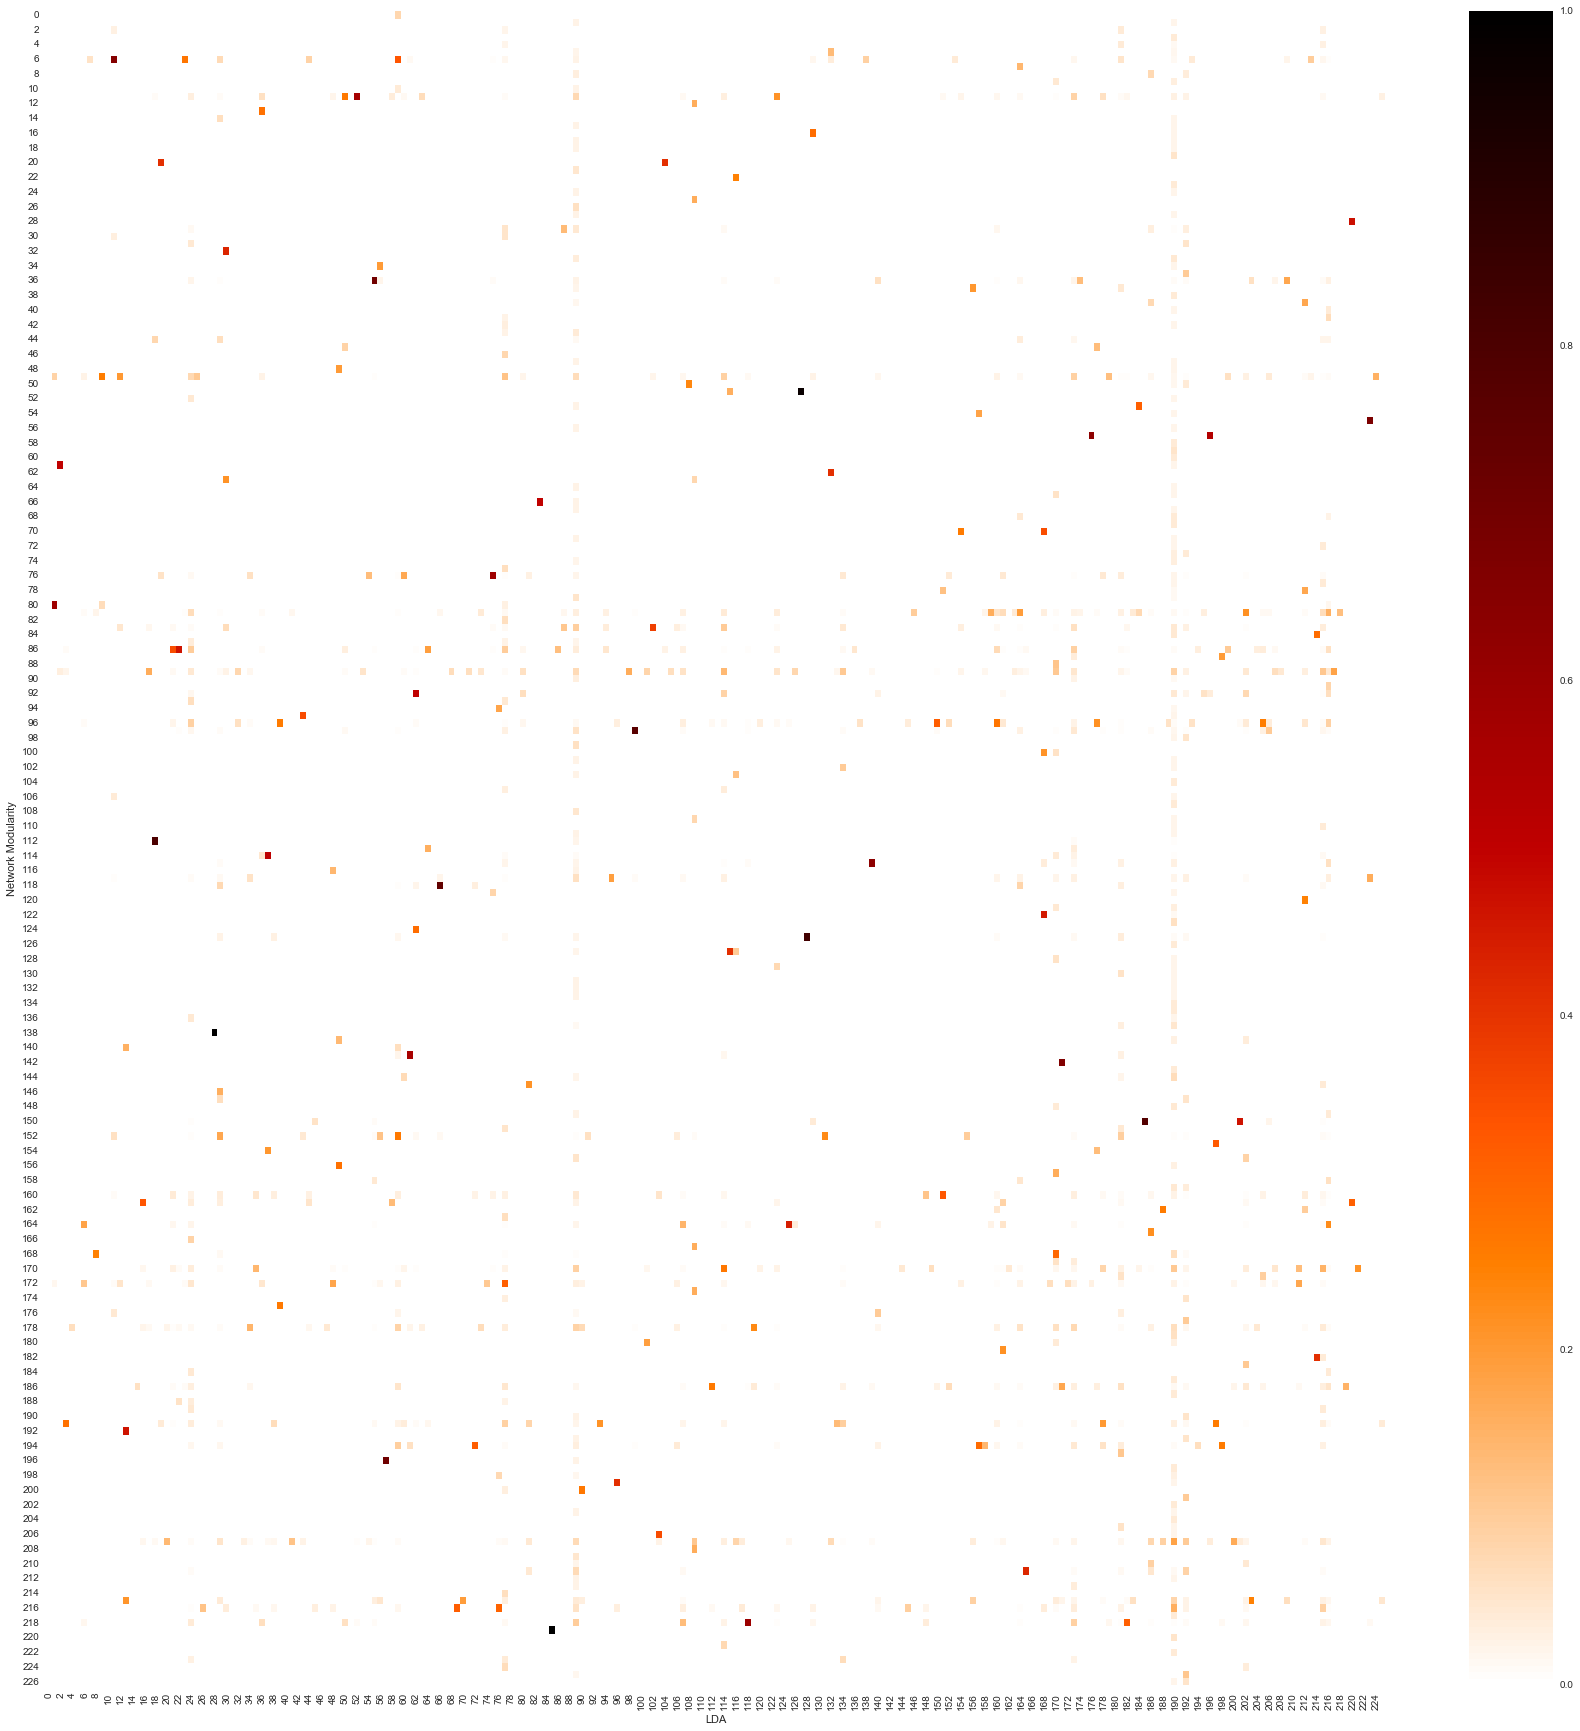

In [44]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(similarities, xticklabels=2, yticklabels=2, cmap=plt.cm.gist_heat_r)
plt.xlabel("LDA")
plt.ylabel("Network Modularity")

# Size to topic table + keywords

In [45]:
import itertools

def save_keyword_table(topics, file_path):
    result = {}
    for topic in topics:
        items = list(map(lambda x: x.values.tolist(), topic[1]))
        keywords = sorted(list(itertools.chain(*items)), key=lambda x: x[1], reverse=True)
        keywords = list(map(lambda x: x[0], keywords))[:10]
        result[topic[0]] = (len(topic[1]), keywords)
    return result

In [46]:
def community_to_keywords(com, docs, filename):
    topics = {}

    for i in range(max(com.membership) + 1):
        for v in com.subgraph(i).vs():
            topic_no = i
            try:
                topics[topic_no]
            except KeyError:
                topics[topic_no] = []

            topics[topic_no].append(docs[v['name']]['keywords'])

    topics = sorted(topics.items(), key=lambda x: len(x[1]), reverse=True)

    return save_keyword_table(topics, 'tmp/' + filename)

In [63]:
lda_items = pickle.load(open('tmp/count_226_lda_items.pickle', 'rb'))
topics = {}

for k, v in lda_items:
    topic_no = v['topic_most_pr']
    try:
        topics[topic_no]
    except KeyError:
        topics[topic_no] = []

    topics[topic_no].append(docs[k]['keywords'])
    
topics = sorted(topics.items(), key=lambda x: len(x[1]), reverse=True)

lda_keywords = save_keyword_table(topics, 'tmp/lda_keywordtable.csv')

In [312]:
net_keywords = community_to_keywords(community, docs, 'network_keywordtable.csv')

In [ ]:
lda_keywords = community_to_keywords(community_lda, docs, 'lda_cosine_keywordtable.csv')

In [34]:
similarities = pickle.load(open('tmp/similarities.pickle', 'rb'))

In [48]:
a = similarities[6]
m = max(range(len(a)), key=lambda x: a[x])
m

11

In [313]:
import csv

sorted_1 = sorted(net_keywords.items(), key=lambda x: x[1][0], reverse=True)
sorted_2 = sorted(lda_keywords.items(), key=lambda x: x[1][0], reverse=True)

rows = []
for i in range(len(net_keywords)):
    row = [i+1]
    try:
        row += [sorted_1[i][0], sorted_1[i][1][0], sorted_1[i][1][1]]
    except:
        row += ['', '']
        
    try:
        row += [sorted_2[i][0], sorted_2[i][1][0], sorted_2[i][1][1]]
    except:
        row += ['', '']
    
    rows.append(row)
    

with open('tmp/keywords.csv', 'w+') as file:    
    for row in rows:
        writer = csv.writer(file, delimiter=';')
        writer.writerow(row)

In [62]:
lda_keywords.keys()

dict_keys([0, 1, 2, 4, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 34, 35, 37, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 54, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 110, 111, 112, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 150, 151, 152, 153, 154, 155, 156, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225])

In [314]:
import csv

rows = []
for i, row in enumerate(similarities):
    a = row
    lda =  max(range(len(a)), key=lambda x: a[x])
    sim =  max(a)
    rows.append([i, net_keywords[i][0], net_keywords[i][1], lda, lda_keywords[lda][0], lda_keywords[lda][1], sim])

with open('tmp/matching.csv', 'w+') as file:    
    for row in sorted(rows, key=lambda x: x[1], reverse=True):
        writer = csv.writer(file, delimiter=';')
        writer.writerow(row)

TypeError: object of type 'numpy.float64' has no len()

# Evaluaton

In [13]:
g = ig.Graph.Read_GML('tmp/subgraph_01.gml')

In [14]:
sg = g.es.select(weight_ge=0.2).subgraph()

In [15]:
community = sg.community_multilevel(weights='weight')

In [465]:
def add_community_to_graph(graph, com):
    for i in range(max(com.membership) + 1):
        for v in com.subgraph(i).vs():
            node = graph.vs().find(name=v['name'])
            node['Community'] = i

### Modularity

In [68]:
print("Network Communities Modularity {}".format(sg.modularity(community.membership)))

Network Communities Modularity 0.8243999357460129


### Network

In [407]:
add_community_to_graph(sg, community)
sg.vs[0]

igraph.Vertex(<igraph.Graph object at 0x12177ee58>, 0, {'community': 195, 'name': '2016-05-06-58', 'Weight': 487, 'Community': 89})

In [76]:
sg.write_gml('tmp/network_community.gml')

### Overall Similarity

In [169]:
import math
from scipy.sparse import vstack

def overall_similarity(vectors):
    similarity_topics = {}
    for k, values in vectors.items():
        matx = vstack((values))
        similarity_topics[k] = np.sum(cosine_similarity(matx, matx)) / math.pow(len(values), 2)

    return sum(similarity_topics.values()) / len(similarity_topics.values())

In [394]:
topics = {}

for i in range(max(community.membership) + 1):
    for v in community.subgraph(i).vs():
        topic_no = i
        try:
            topics[topic_no]
        except KeyError:
            topics[topic_no] = []

        topics[topic_no].append(docs[v['name']]['tfidf'])
        
overall_similarity(topics)

0.54230160456663623

In [383]:
topic = topics[6]
np.dot((topic[0] + topic[1]).toarray() / len(topic), (topic[0] + topic[1]).toarray().T / len(topic))

array([[  2.94635360e-06]])

In [374]:
import scipy as scipy 

topic = topics[0]
matx = scipy.sparse.vstack((topic))
np.sum(cosine_similarity(matx, matx)) / math.pow(len(topic), 2)

0.99999999999999989

## LDA

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(lda_vectors, net_vectors)

matching = {}
for i, a in enumerate(similarities):
    b =  max(range(len(a)), key=lambda x: a[x])
    matching[i] = b

print(matching)

{0: 0, 1: 80, 2: 61, 3: 191, 4: 178, 5: 0, 6: 164, 7: 6, 8: 168, 9: 49, 10: 0, 11: 6, 12: 49, 13: 192, 14: 0, 15: 186, 16: 161, 17: 89, 18: 112, 19: 20, 20: 207, 21: 86, 22: 86, 23: 6, 24: 86, 25: 49, 26: 216, 27: 0, 28: 138, 29: 152, 30: 32, 31: 0, 32: 89, 33: 207, 34: 178, 35: 170, 36: 13, 37: 114, 38: 191, 39: 175, 40: 0, 41: 207, 42: 0, 43: 95, 44: 6, 45: 150, 46: 0, 47: 178, 48: 172, 49: 156, 50: 11, 51: 0, 52: 11, 53: 89, 54: 76, 55: 36, 56: 34, 57: 196, 58: 161, 59: 6, 60: 76, 61: 141, 62: 92, 63: 11, 64: 86, 65: 0, 66: 118, 67: 0, 68: 89, 69: 216, 70: 215, 71: 89, 72: 194, 73: 178, 74: 172, 75: 76, 76: 216, 77: 172, 78: 0, 79: 0, 80: 92, 81: 145, 82: 0, 83: 66, 84: 0, 85: 219, 86: 86, 87: 29, 88: 0, 89: 218, 90: 200, 91: 152, 92: 0, 93: 191, 94: 86, 95: 117, 96: 199, 97: 0, 98: 89, 99: 97, 100: 0, 101: 180, 102: 83, 103: 206, 104: 20, 105: 89, 106: 194, 107: 164, 108: 50, 109: 12, 110: 0, 111: 0, 112: 186, 113: 0, 114: 170, 115: 127, 116: 22, 117: 216, 118: 218, 119: 178, 120: 

In [38]:
for v in sg_lda.vs:
    v['Community'] = docs[v['name']]['topic_most_pr']
sg_lda.vs[0]

### Modularity

In [39]:
membership = []
for v in sg_lda.vs():
    membership.append(v['Community'])

In [67]:
print("LDA Communities Modularity {}".format(sg_lda.modularity(membership)))

LDA Communities Modularity 0.6819538245187293


### Network

In [33]:
for v in sg_lda.vs:
    v['Community'] = matching[v['Community']]

In [34]:
sg_lda.vs[0]

igraph.Vertex(<igraph.Graph object at 0x114bd1a98>, 0, {'id': 0.0, 'name': '2016-05-07-165', 'Community': 11})

In [66]:
sg_lda.write_gml('tmp/lda_community.gml')

### Overall Similarity

In [171]:
topics = {}

for k, v in lda_items:
    topic_no = v['topic_most_pr']
    try:
        topics[topic_no]
    except KeyError:
        topics[topic_no] = []

    topics[topic_no].append(docs[k]['tfidf'])

overall_similarity(topics)

NameError: name 'lda_items' is not defined

## LCM

In [531]:
add_community_to_graph(sg_lda, community_lda)
len(sg_lda.vs)

7925

In [532]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

similarities = cosine_similarity(lda_vectors, net_vectors)

matching = {}
matching_count = {}
matching_count = defaultdict(lambda: 0, matching_count)

for i, a in enumerate(similarities):
    b =  max(range(len(a)), key=lambda x: a[x])
    if b in matching.values():
        matching_count[b] += 0.1
        matching[i] = b + matching_count[b]
    else:
        matching[i] = b

print(matching)

{0: 57, 1: 114, 2: 81, 3: 172, 4: 36, 5: 138, 6: 6, 7: 194, 8: 183, 9: 141, 10: 80, 11: 168, 12: 142, 13: 172.1, 14: 186, 15: 161, 16: 125, 17: 216, 18: 207, 19: 89, 20: 192, 21: 215, 22: 186.1, 23: 170, 24: 190, 25: 83, 26: 89.1, 27: 156, 28: 11, 29: 177, 30: 112, 31: 150, 32: 125.1, 33: 207.1, 34: 83.1, 35: 115, 36: 207.2, 37: 76, 38: 170.1, 39: 120, 40: 11.1, 41: 161.1, 42: 194.1, 43: 216.1, 44: 124, 45: 160, 46: 89.2, 47: 216.2, 48: 96, 49: 49, 50: 81.1, 51: 81.2, 52: 81.3, 53: 62, 54: 89.3, 55: 186.2, 56: 76.1, 57: 172.2, 58: 92, 59: 172.3, 60: 172.4, 61: 191, 62: 186.3, 63: 219, 64: 0, 65: 186.4, 66: 97, 67: 207.3, 68: 49.1, 69: 36.1, 70: 81.4, 71: 39, 72: 118, 73: 216.3, 74: 89.4, 75: 194.2, 76: 218, 77: 150.1, 78: 194.3, 79: 164, 80: 83.2, 81: 191.1, 82: 117, 83: 0.1, 84: 51, 85: 26, 86: 11.2, 87: 216.4, 88: 83.3, 89: 164.1, 90: 96.1, 91: 207.4, 92: 0.2, 93: 216.5, 94: 92.1, 95: 0.30000000000000004, 96: 6.1, 97: 168.1, 98: 175, 99: 86, 100: 92.2, 101: 215.1, 102: 150.2, 103: 96

In [533]:
for v in sg_lda.vs:
    v['Community'] = matching[v['Community']]

In [534]:
sg_lda.write_gml('tmp/lda_community.gml')

### Overall Similarity

In [167]:
topics = {}

for i in range(max(community_lda.membership) + 1):
    for v in community_lda.subgraph(i).vs():
        topic_no = i
        try:
            topics[topic_no]
        except KeyError:
            topics[topic_no] = []
        topics[topic_no].append(docs[v['name']]['tfidf'])
        
overall_similarity(topics)

NameError: name 'community_lda' is not defined

# Modularity applied to LDA Similarities

In [77]:
lda_model.minimum_probability=0.0

mat = []
for i, m in enumerate(doc_topic_prob_mat):
    clear_output(wait=True)
    print('{0}\r'.format(i/len(token_keys)))
    a = []
    for n in m:
        if n[1] >= 0.01:
            a.append(n[1])
        else:
            a.append(0)
    mat.append(a)

0.9998899405679067


In [78]:
len(mat)

9086

In [79]:
mat_np = np.mat(mat)
pickle.dump(mat, open('tmp/mat.pickle', 'wb'))
mat_np[1]

matrix([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.01249956,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.0203371 ,  0.        ,  0.        ,
          0.        ,  0.04179488,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.08095506,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.

In [195]:
from gensim import matutils

def hellinger_similarity(vec1, vec2):
    return 1.0 - matutils.hellinger(np.asarray(vec1), np.asarray(vec2))

In [196]:
print(hellinger_similarity(mat_np[0], mat_np[1]))

0.248986713254


In [337]:
mat_np = pickle.load(open('tmp/count_226_mat.pickle', 'rb'))
len(mat_np)

9086

## Add LDA to docs

In [338]:
for i, key in enumerate(token_keys):
    docs[key]['lda'] = scipy.sparse.csr_matrix(mat_np[i])
  
docs['2016-05-20-28']['lda']

<1x226 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [197]:
g = ig.Graph()
for i, key in enumerate(token_keys):
    g.add_vertices(key)
    
print(g.vcount())

9086


In [198]:
g.delete_edges(g.es)
edges = []
for i, source in enumerate(token_keys):
    print('{0}\r'.format(i/len(token_keys)))
    for i_2, target in enumerate(token_keys):
        edges.append((source, target))
    clear_output(wait=True)
            
g.add_edges(edges)  
edges = [] 
print(g.ecount())

82555396


In [199]:
from sklearn.metrics.pairwise import cosine_similarity

for i, source in enumerate(token_keys):
    clear_output(wait=True)
    print('{0}\r'.format(i/len(token_keys)))
    for j, target in enumerate(token_keys):  
        g.es[count]["weight"] = hellinger_similarity(mat_np[i], mat_np[j])

print(g.ecount())

0.9998899405679067
82555396


In [200]:
g.simplify(multiple=True, loops=True, combine_edges="max")
print(g.ecount())

41273155


In [201]:
sg = g.es.select(weight_ge=0.1).subgraph()

In [202]:
sg.write_gml('tmp/igraph_lda_01.gml')

In [204]:
print("Nodes {}".format(sg.vcount()))
print("Edges {}".format(sg.ecount()))

Nodes 9086
Edges 29173924


# Load LDA Network

In [385]:
g_lda = ig.Graph.Read_GML('tmp/hell_igraph_lda_01.gml')

In [386]:
sg_lda = g_lda.es.select(weight_ge=0.5).subgraph()

In [387]:
print("Nodes {}".format(sg_lda.vcount()))
print("Edges {}".format(sg_lda.ecount()))

Nodes 7582
Edges 111082


In [388]:
# community = sg.community_infomap(edge_weights='weight')
community_lda = sg_lda.community_multilevel(weights='weight')
# community = sg.community_leading_eigenvector(weights='weight')

In [427]:
network_properties(sg_lda, community_lda)

Nodes 7925
Edges 221933
Diameter 22
LCC 7549
APL 5.957700836641584
AD 56.00832807570978
Giant Size 857
NO of Communities 136
Modularity 0.7231432555672551


In [434]:
with open('tmp/lda_network_docs.txt', 'w+') as file:
    for i in range(max(community_lda.membership) + 1):
        for v in community_lda.subgraph(i).vs():
            file.write("Topic:{} File:{} Title:{}\n".format(i, v['name'], docs[v['name']]['webTitle']))

7925

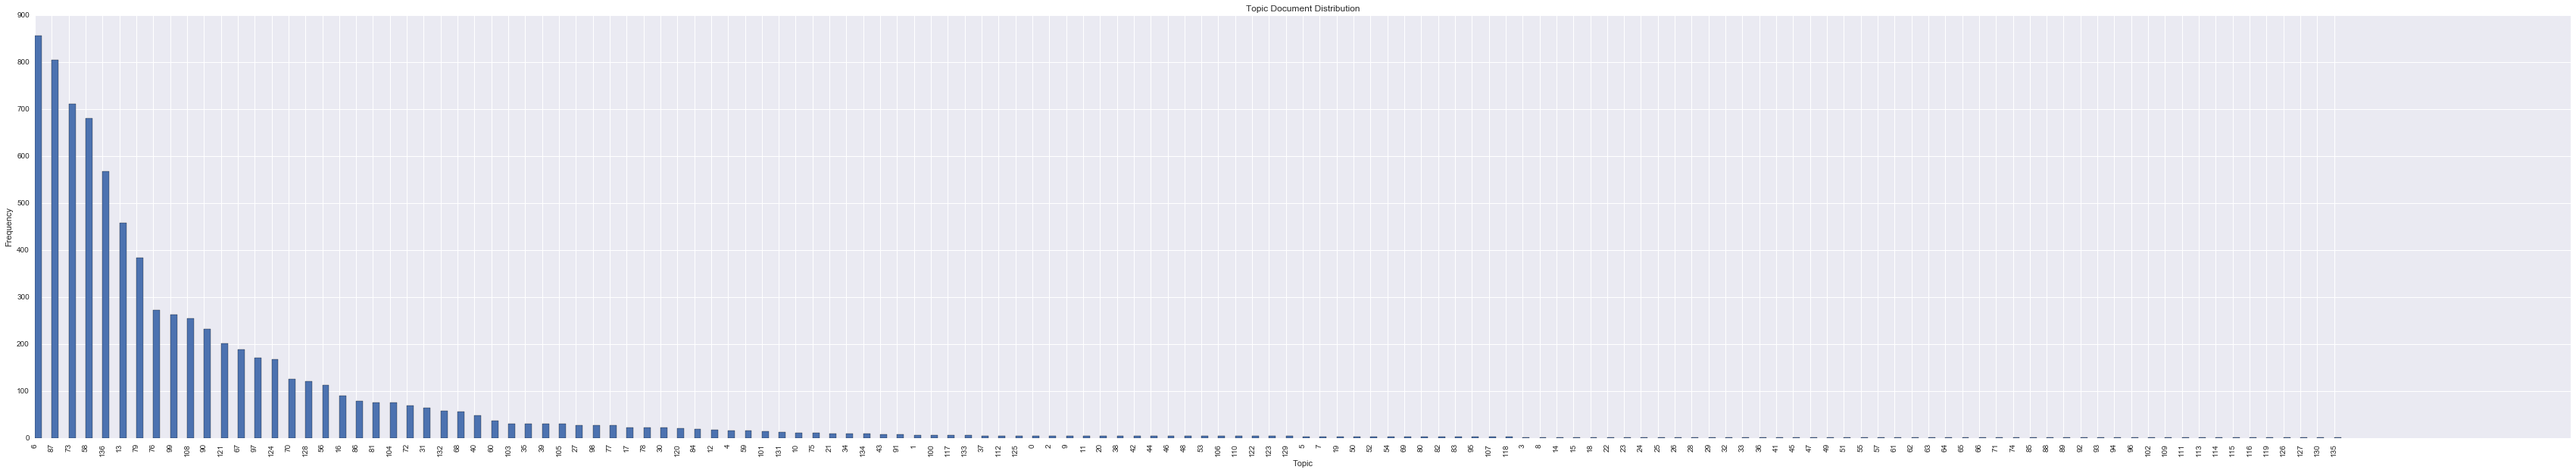

In [441]:
community_to_size_chart(community_lda)

# Hierarchical Clustering

In [82]:
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(X_tfidf)

In [83]:
from scipy.cluster.hierarchy import ward, dendrogram

print("Start Hierarchical Clustering...")

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

print("Done Hierarchical Clustering...")

Start Hierarchical Clustering...
Done Hierarchical Clustering...


In [84]:
pickle.dump(linkage_matrix, open('tmp/linkage_matrix.pickle', 'wb'))

In [189]:
from scipy.cluster.hierarchy import fclusterdata, fcluster

def cluster_indices(cluster_assignments):
    n = cluster_assignments.max()
    indices = []
    for cluster_number in range(1, n + 1):
        indices.append(np.where(cluster_assignments == cluster_number)[0])
    return indices

# Compute the clusters.
cutoff = 1.0
cluster_assignments = fcluster(linkage_matrix, 3, criterion="distance")

# Print the indices of the data points in each cluster.
num_clusters = cluster_assignments.max()
print("%d clusters" % num_clusters)
indices = cluster_indices(cluster_assignments)

print("Giant Size:", len(max(indices, key=lambda x: len(x))))

# for k, ind in enumerate(indices):
#     print("cluster", k + 1, " (Length:)", len(ind), "=", ind)

for k, ind in enumerate(indices):
    for i in ind:
        docs[token_keys[i]]['ward'] = k
        
print(docs['2016-05-24-283']['ward'])

1087 clusters
Giant Size: 88
746


In [190]:
ward_items = sorted(docs.items(), key=lambda x: x[1]['ward'])

In [191]:
with open('tmp/ward_docs.txt', 'w+') as file:
    for item in ward_items:
        file.write("Topic:{} File:{} Title:{}\n".format(item[1]['ward'], item[0], item[1]['webTitle']))

In [192]:
topics = {}

for k, v in ward_items:
    topic_no = v['ward']
    try:
        topics[topic_no]
    except KeyError:
        topics[topic_no] = []

    topics[topic_no].append(docs[k]['tfidf'])

overall_similarity(topics)

0.41174942463129155

136


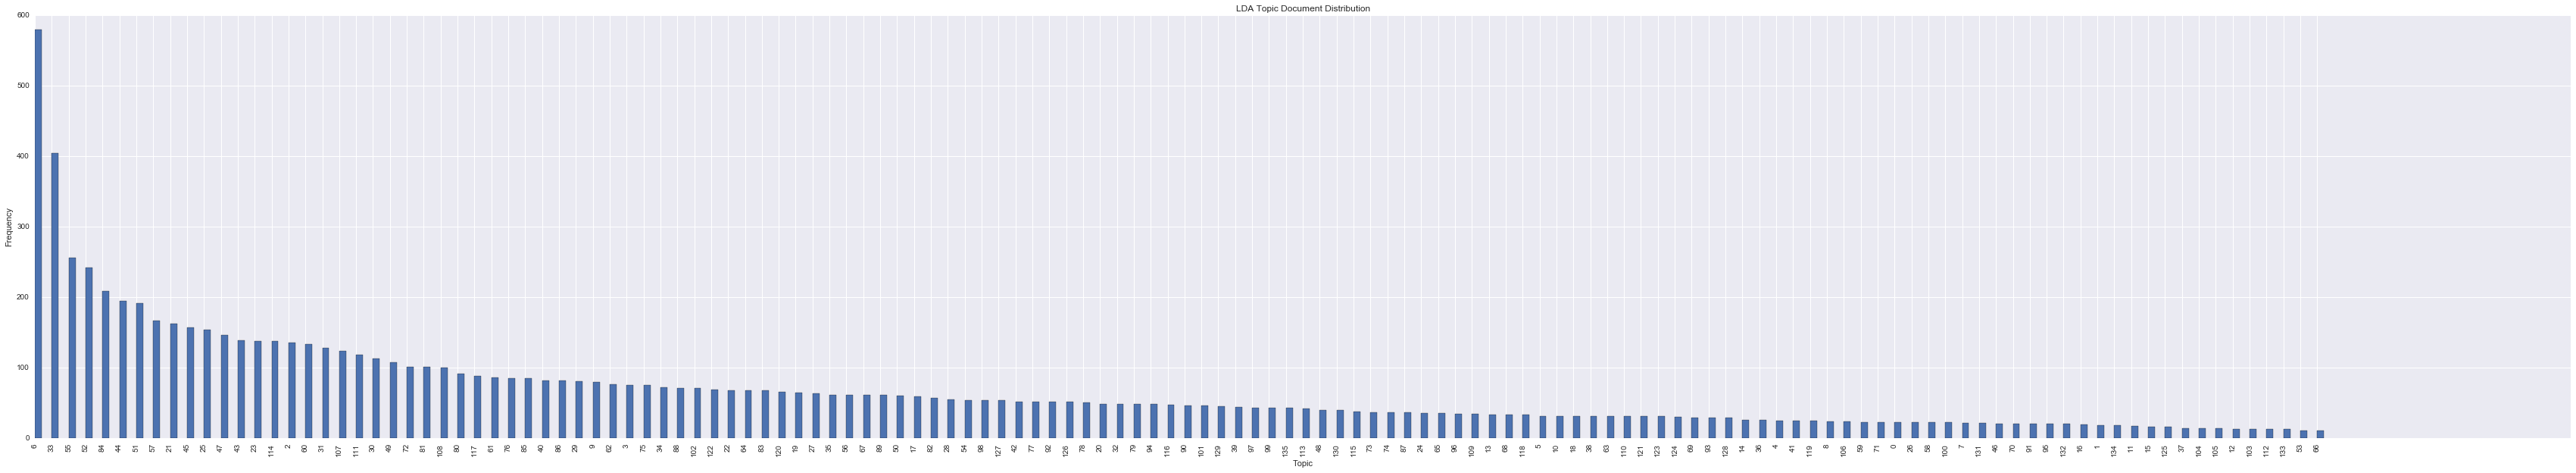

In [162]:
topics = {}

for i in range(num_clusters):
    topics[i] = []
    
for item in ward_items:
    topic_no = item[1]['ward']
    topics[topic_no].append(item[0])
    
print(len(topics.keys()))

x_data = []
y_data = []
for key, value in sorted(topics.items(), key=lambda x: len(x[1]), reverse=True):
    x_data.append(key)
    y_data.append(len(value))

ind = np.arange(0, len(y_data) * 2, 2)
fig = plt.figure(figsize=(60,10))
plt.bar(ind, y_data)
plt.xticks(ind, x_data, rotation=90)
plt.title("LDA Topic Document Distribution")
plt.xlabel("Topic")
plt.ylabel("Frequency")
fig.savefig('tmp/size_chart_lda.png')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right");

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('tmp/ward_clusters.png', dpi=200) #save figure as ward_clusters